In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, udf, size, col, explode
from pyspark.sql.types import ArrayType, StringType

import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
spark = SparkSession.builder \
    .appName("SPARK TRAB - QUESTION 1 B") \
    .getOrCreate()

In [3]:
df_orig = spark.read.option("header", "false").option("delimiter", "\t").csv("./data/debate-tweets.tsv")

## Objetivo
O objetivo desse Notebook é, a partir dos dados de tweets brasileiros de 2014 durante o período de eleições, responder a seguinte pergunta:

"Quais as Hashtags mais utilizadas por dia?"

In [4]:
df = df_orig.select("_c0", "_c1", "_c8")

df = df.withColumnRenamed("_c0", "id") \
                     .withColumnRenamed("_c1", "content") \
                     .withColumnRenamed("_c8", "date")

In [5]:
df.show()

+------------------+--------------------+----------+
|                id|             content|      date|
+------------------+--------------------+----------+
|522394422710136832|@anacddd verdade,...|2014-10-15|
|522394422806581248|              Que ñ*|2014-10-15|
|522394422731100160| Vou quebrar a Bruna|2014-10-15|
|522394422810783745|agora vou p segun...|2014-10-15|
|522394423137943553|Me sinto tão bem ...|2014-10-15|
|522394423188271104|Eu estou aqui, de...|2014-10-15|
|522394423238606848|Quando vai embora...|2014-10-15|
|522394423528022016|@paynecaralhudo k...|2014-10-15|
|522394423632875521|Conceição da Barr...|2014-10-15|
|522394424010362881| @Maniavato te amo ♥|2014-10-15|
|522394424048091138|Alg me curtindo rs ♡|2014-10-15|
|522394424010358784|@MiiluAA No, porq...|2014-10-15|
|522394423741906944|#EMABiggestFansJu...|2014-10-15|
|522394424568213505|@raizabatista dev...|2014-10-15|
|522394424920506368|Me senti ate d fe...|2014-10-15|
|522394424811458560|qual o sentido de...|2014-

In [6]:
df = df.withColumn("date_", to_date(df["date"], "yyyy-MM-dd"))

df.show()

+------------------+--------------------+----------+----------+
|                id|             content|      date|     date_|
+------------------+--------------------+----------+----------+
|522394422710136832|@anacddd verdade,...|2014-10-15|2014-10-15|
|522394422806581248|              Que ñ*|2014-10-15|2014-10-15|
|522394422731100160| Vou quebrar a Bruna|2014-10-15|2014-10-15|
|522394422810783745|agora vou p segun...|2014-10-15|2014-10-15|
|522394423137943553|Me sinto tão bem ...|2014-10-15|2014-10-15|
|522394423188271104|Eu estou aqui, de...|2014-10-15|2014-10-15|
|522394423238606848|Quando vai embora...|2014-10-15|2014-10-15|
|522394423528022016|@paynecaralhudo k...|2014-10-15|2014-10-15|
|522394423632875521|Conceição da Barr...|2014-10-15|2014-10-15|
|522394424010362881| @Maniavato te amo ♥|2014-10-15|2014-10-15|
|522394424048091138|Alg me curtindo rs ♡|2014-10-15|2014-10-15|
|522394424010358784|@MiiluAA No, porq...|2014-10-15|2014-10-15|
|522394423741906944|#EMABiggestFansJu...

In [7]:
# Função simples responsáveis por extrair hashtags utilizando expressão regulares

def extract_hashtags(text):
    return re.findall(r'#(\w+)', text)

In [8]:
extract_hashtags_udf = udf(extract_hashtags, ArrayType(StringType()))

# retirando as hashtags
df_hashtags = df.withColumn("hashtags", extract_hashtags_udf(df["content"]))

hashtags_and_dates = df_hashtags.select("hashtags", "date").filter(size(col("hashtags")) > 0)

hashtags_and_dates = hashtags_and_dates.withColumn("hashtag", explode("hashtags")).select("date", "hashtag").dropna()

hashtags_and_dates.show()

+----------+--------------------+
|      date|             hashtag|
+----------+--------------------+
|2014-10-15|          QueroNoTVZ|
|2014-10-15|EMABiggestFansJus...|
|2014-10-15|EMABiggestFansJus...|
|2014-10-15|    EMABiggestFans1D|
|2014-10-15|          QueroNoTVZ|
|2014-10-15|    EMABiggestFans1D|
|2014-10-15|EMABiggestFansJus...|
|2014-10-15|       SorrisoMaroto|
|2014-10-15|            Encontro|
|2014-10-15|             tãlegal|
|2014-10-15|EMABiggestFansJus...|
|2014-10-15|    EMABiggestFans1D|
|2014-10-15|               beach|
|2014-10-15|                  sp|
|2014-10-15|                 sun|
|2014-10-15|    EMABiggestFans1D|
|2014-10-15|              TopPop|
|2014-10-15|                 112|
|2014-10-15|EMABiggestFansJus...|
|2014-10-15|    EMABiggestFans1D|
+----------+--------------------+


In [9]:
hashtags_and_dates.select("date").distinct().show()

+----------+
|      date|
+----------+
|2014-10-15|
|       0.0|
|2014-10-16|
|2014-10-17|
|2014-10-18|
|2014-10-19|
|2014-10-20|
+----------+


In [10]:
hashtags_and_dates = hashtags_and_dates.groupBy("date", "hashtag").count()

hashtags_and_dates = hashtags_and_dates.orderBy(col("count").desc())

hashtags_and_dates.show()

+----------+--------------------+-----+
|      date|             hashtag|count|
+----------+--------------------+-----+
|2014-10-16|    EMABiggestFans1D|68633|
|2014-10-16|EMABiggestFansJus...|59012|
|2014-10-17|EMABiggestFansJus...|49488|
|2014-10-17|    EMABiggestFans1D|48001|
|2014-10-15|    EMABiggestFans1D|34547|
|2014-10-19|EMABiggestFansJus...|33582|
|2014-10-19|    EMABiggestFans1D|29613|
|2014-10-15|EMABiggestFansJus...|28105|
|2014-10-18|EMABiggestFansJus...|27454|
|2014-10-18|    EMABiggestFans1D|27226|
|2014-10-16|        camilasayshi|10528|
|2014-10-20|EMABiggestFansJus...|10452|
|2014-10-20|    EMABiggestFans1D| 7425|
|2014-10-15|         StealMyGirl| 6280|
|2014-10-15|    bigpaynodanceoff| 4250|
|2014-10-16|         DebateNoSBT| 3308|
|2014-10-16|     CartersNewVideo| 3207|
|2014-10-19|LuanSantanaNaHora...| 3144|
|2014-10-17|          QueroNoTVZ| 3075|
|2014-10-17|      TheVoiceBrasil| 2797|
+----------+--------------------+-----+


In [11]:
top_20_hashtags_15 = hashtags_and_dates.filter(col("date") == "2014-10-15").limit(10)

top_20_hashtags_16 = hashtags_and_dates.filter(col("date") == "2014-10-16").limit(10)

top_20_hashtags_17 = hashtags_and_dates.filter(col("date") == "2014-10-17").limit(10)

top_20_hashtags_18 = hashtags_and_dates.filter(col("date") == "2014-10-18").limit(10)

top_20_hashtags_19 = hashtags_and_dates.filter(col("date") == "2014-10-19").limit(10)

top_20_hashtags_20 = hashtags_and_dates.filter(col("date") == "2014-10-20").limit(10)

In [12]:
hashtags_15 = top_20_hashtags_15.toPandas()
hashtags_16 = top_20_hashtags_16.toPandas()
hashtags_17 = top_20_hashtags_17.toPandas()
hashtags_18 = top_20_hashtags_18.toPandas()
hashtags_19 = top_20_hashtags_19.toPandas()
hashtags_20 = top_20_hashtags_20.toPandas()

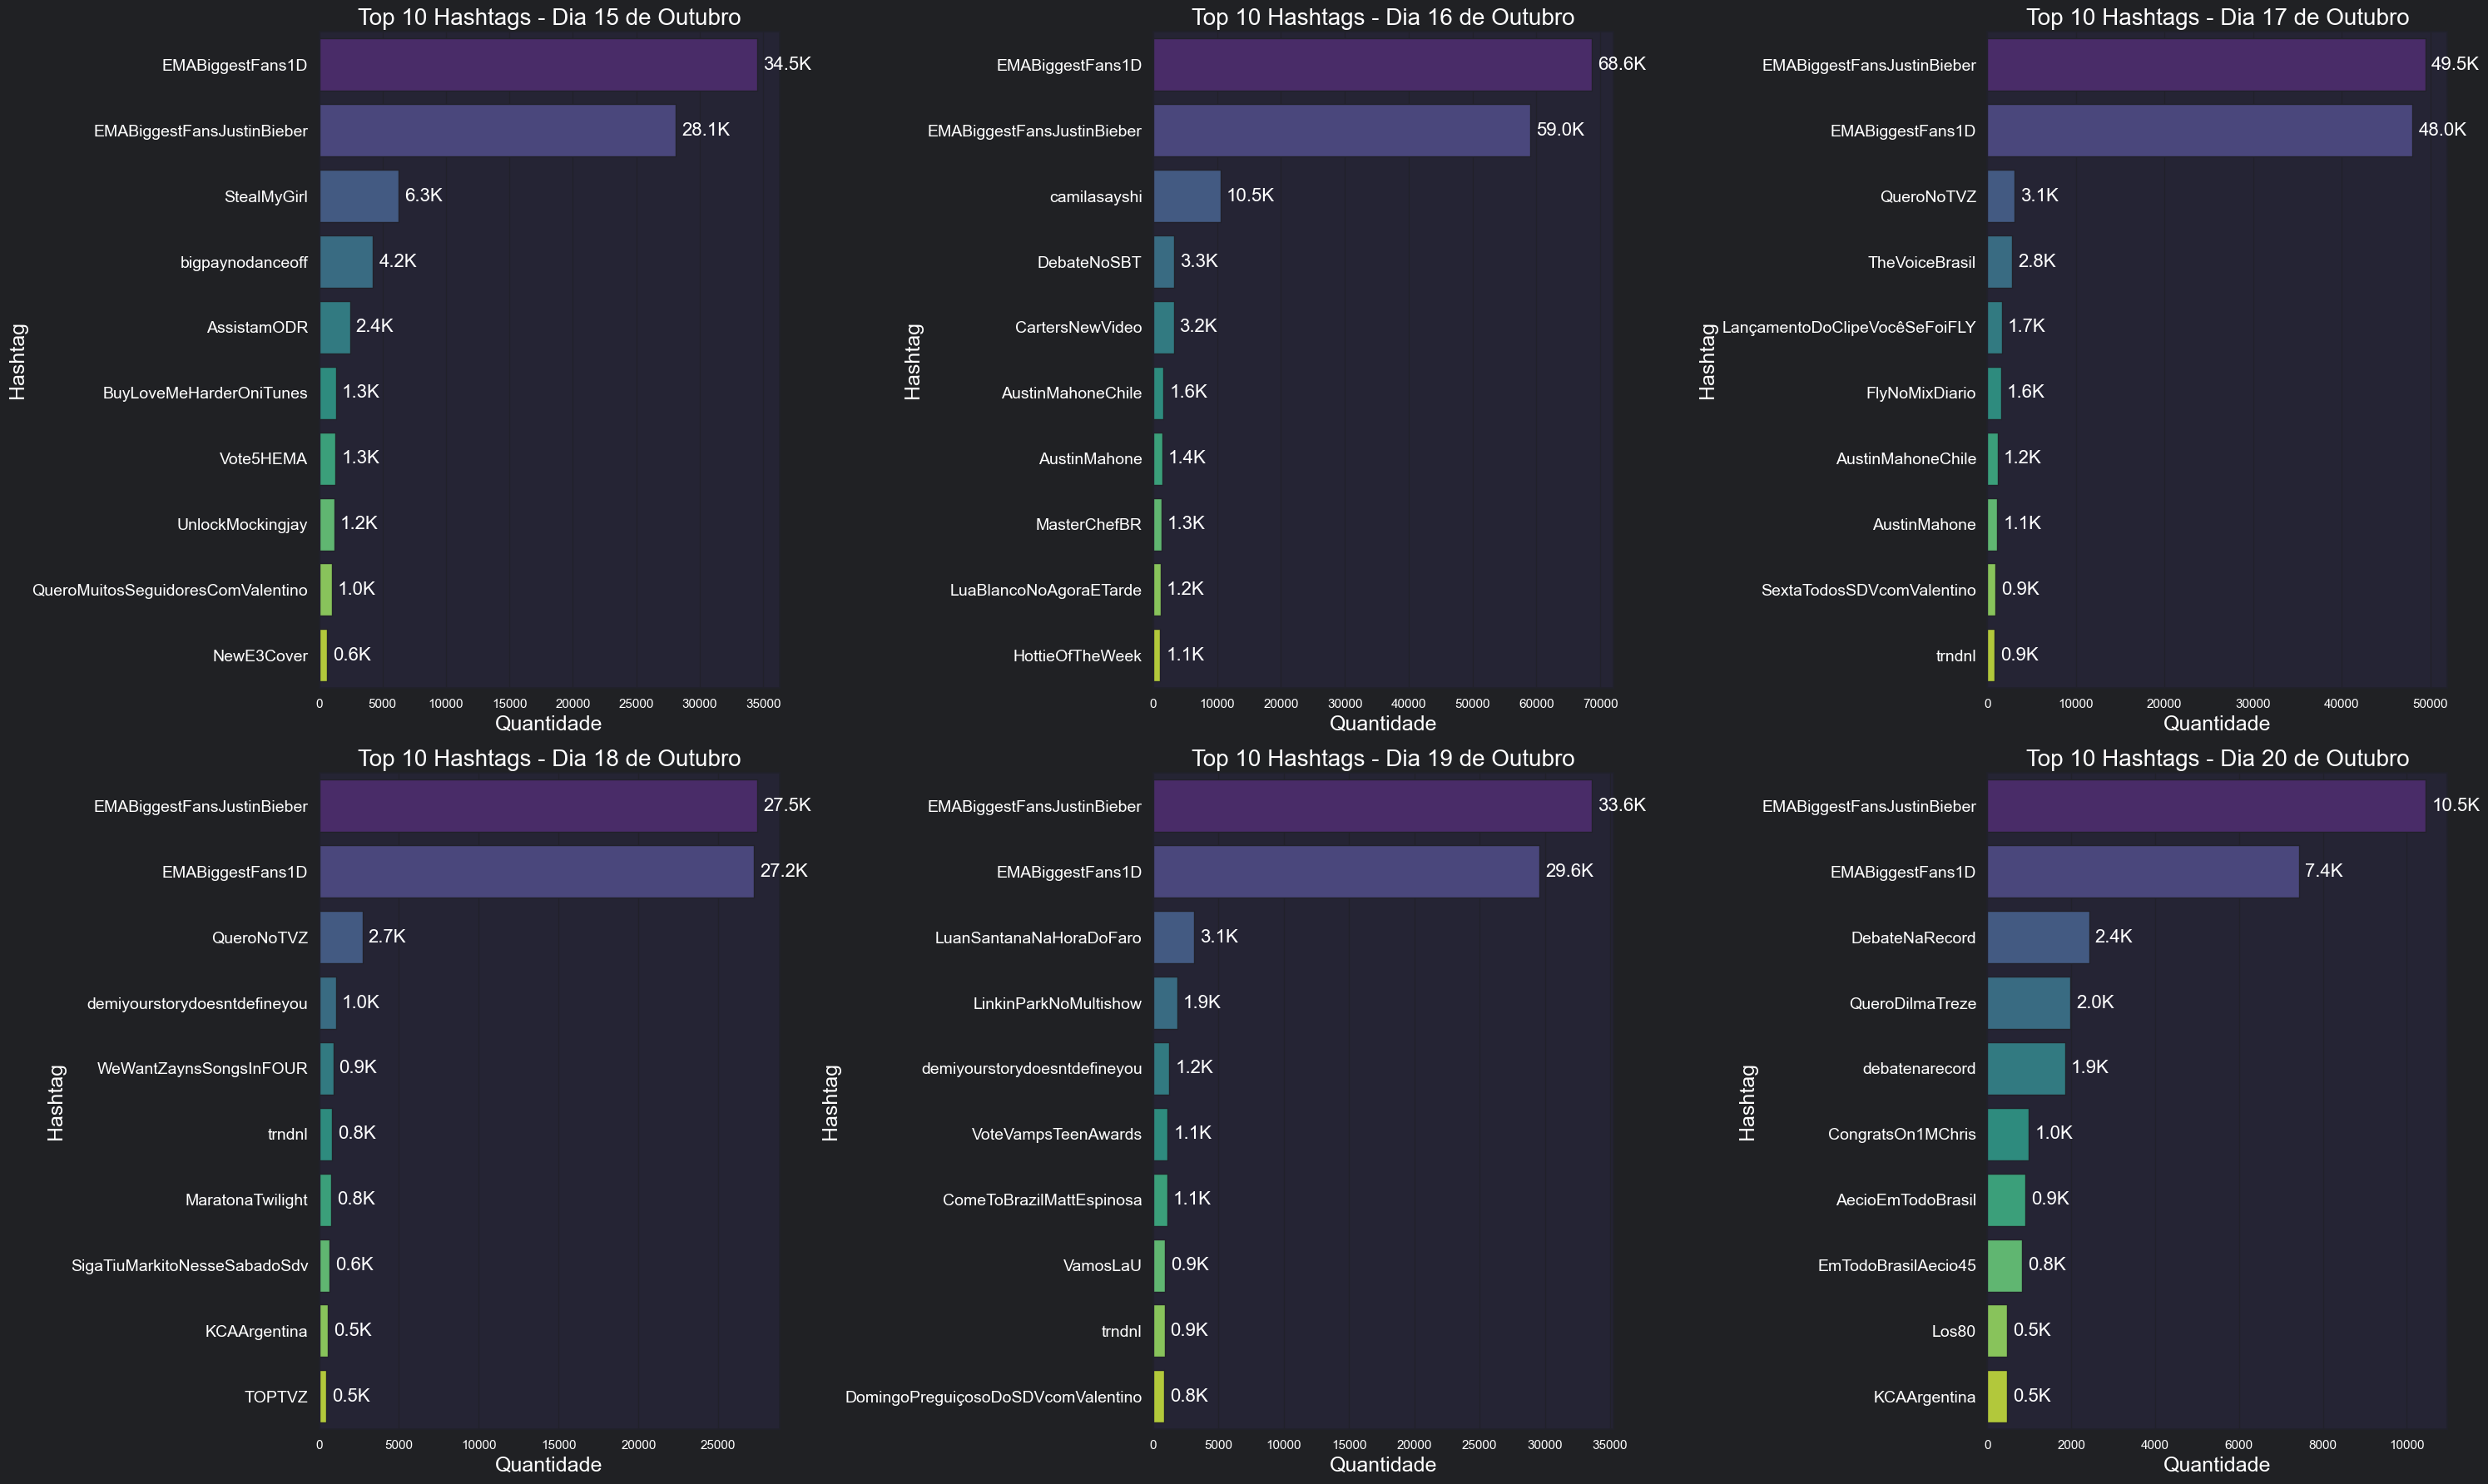

In [45]:
sns.set(style="darkgrid", rc={"axes.facecolor": "#252434", "figure.facecolor": "#202124", "axes.edgecolor": "#21212a", "grid.color": "#21212a"}) 

fig, axes = plt.subplots(2, 3, figsize=(30, 18), facecolor='#202124')

dataframes = [hashtags_15, hashtags_16, hashtags_17, hashtags_18, hashtags_19, hashtags_20]
titles = [
    'Top 10 Hashtags - Dia 15 de Outubro', 
    'Top 10 Hashtags - Dia 16 de Outubro', 
    'Top 10 Hashtags - Dia 17 de Outubro', 
    'Top 10 Hashtags - Dia 18 de Outubro', 
    'Top 10 Hashtags - Dia 19 de Outubro', 
    'Top 10 Hashtags - Dia 20 de Outubro'
]

axes = axes.flatten()

for ax, data, title in zip(axes, dataframes, titles):
    barplot = sns.barplot(ax=ax, x='count', y='hashtag', data=data, hue='hashtag', legend=False, palette='viridis', edgecolor="#21212a")
    
    for p in barplot.patches:
        width = p.get_width()
        height = p.get_height()
        barplot.annotate(f"{width / 1000:.1f}K",
                         (p.get_x() + width, p.get_y() + height / 2),
                         ha='left', va='center',
                         xytext=(5, 0), textcoords='offset points',
                         fontsize=16, rotation=0, color='#ffffff')

    ax.set_xlabel('Quantidade', color='#ffffff', fontsize = 18)  
    ax.set_ylabel('Hashtag', color='#ffffff', fontsize = 18)  
    ax.set_title(title, color='#ffffff', fontsize = 20) 
    ax.tick_params(axis='y', colors='#ffffff', labelsize=14)
    ax.tick_params(axis='x', colors='#ffffff')
    ax.set_facecolor('#252434')

plt.tight_layout()
plt.savefig('./outcome/Q1/top_hashtags_dias.pdf', facecolor='#202124', bbox_inches='tight')
plt.show()
